In [60]:
%config IPCompleter.greedy=True
%matplotlib inline

In [59]:
import string
import flair

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from tqdm import tqdm
from collections import Counter, OrderedDict
from nltk.corpus import stopwords
from IPython.display import clear_output
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [58]:
nltk.download("stopwords")
clear_output()

## Loading the file into a DataFrame

In [4]:
def load_file_to_df(file_name) -> pd.DataFrame:
    reviews_file = open(file_name,'rt')
    frames = []
    dict_to_append = {}
    for i, line in tqdm(enumerate(reviews_file)):
        if line == "\n" and len(dict_to_append) > 0:
            frames.append(pd.DataFrame.from_records([dict_to_append]))
            dict_to_append = {}
        else:
            content = line.rstrip().split(':', 1)
            key = content[0]
            value = content[1].lstrip()
            dict_to_append[key] = value                
    return pd.concat(frames)

In [5]:
df = load_file_to_df('Cell_Phones_&_Accessories.txt')

868230it [01:52, 7718.34it/s] 


In [6]:
df.describe()

,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
count,78930,78930,78930,78930,78930,78930,78930,78930,78930,78930
unique,7438,7150,944,68041,63370,1305,5,4431,60321,77390
top,B0009B0IX4,Plantronics Voyager 510 Bluetooth Headset [Ret...,unknown,unknown,unknown,0/0,5.0,1168300800,Great Product,I had been very happy with my Motorola phone u...
freq,3443,3443,43287,2276,2276,34920,30253,519,211,20


## Preprocessing of the data

In [7]:
def change_column_type(df: pd.DataFrame, column_name: str, new_dtype: type):
    df[column_name] = df[column_name].astype(new_dtype)

In [8]:
def split_review_helpfulness(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Splits review/helpfulness to two distinct columns:
        review/viewsCount: how many users saw this review
        review/helpfulnessCount: how many users found the review helpful
    Args:
        df: DataFrame i which review/helpfulness column will be split
    Returns:
        df after modification of the columns
    '''
    df = df.copy()
    df[['review/helpfulnessCount', 'review/viewsCount']] = \
        df['review/helpfulness'].str.split('/', expand=True)
    change_column_type(df, 'review/viewsCount', int)
    change_column_type(df, 'review/helpfulnessCount', int)
    df['review/helpfulnessFraction'] =  df['review/helpfulnessCount'] / (df['review/viewsCount'] + 1e-10)
    df.pop('review/helpfulness')
    return df

In [9]:
def preprocess_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Calls split_review_helpfulness on a DataFrame and changes the column type of review/score to float. 
    Args:
        df: DataFrame to be preprocessed
    Returns:
        df after preprocessing
    '''
    df = split_review_helpfulness(df)
    change_column_type(df, 'review/score', float)
    return df.reset_index(drop=True)

In [10]:
df = preprocess_dataframe(df)

In [11]:
df.describe()

,review/score,review/helpfulnessCount,review/viewsCount,review/helpfulnessFraction
count,78930.000000,78930.000000,78930.000000,78930.000000
mean,3.523337,3.041581,3.956810,0.426029
std,1.524245,12.302882,13.354536,0.454090
min,1.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000
50%,4.000000,1.000000,1.000000,0.125000
75%,5.000000,3.000000,4.000000,1.000000
max,5.000000,1222.000000,1243.000000,1.000000


In [12]:
df.describe(include=object)

,product/productId,product/title,product/price,review/userId,review/profileName,review/time,review/summary,review/text
count,78930,78930,78930,78930,78930,78930,78930,78930
unique,7438,7150,944,68041,63370,4431,60321,77390
top,B0009B0IX4,Plantronics Voyager 510 Bluetooth Headset [Ret...,unknown,unknown,unknown,1168300800,Great Product,I had been very happy with my Motorola phone u...
freq,3443,3443,43287,2276,2276,519,211,20


In [13]:
print("Uknown prices:", df['product/price'].value_counts().loc['unknown'],\
      "\nUnknown users:", df['review/userId'].value_counts().loc['unknown'])

Uknown prices: 43287 
Unknown users: 2276


Data consists of about 79000 reviews.
<br/> <br/>
Each review is characterized by: <br/>
**product/productId**: asin, e.g. amazon.com/dp/B00006HAXW <br/>
**product/title**: title of the product <br/>
**product/price**: price of the product <br/>
**review/userId**: id of the user, e.g. A1RSDE90N6RSZF <br/>
**review/profileName**: name of the user <br/>
**review/helpfulnessFraction**: fraction of users who found the review helpful <br/>
**review/score**: rating of the product <br/>
**review/time**: time of the review (unix time) <br/>
**review/summary**: review summary <br/>
**review/text**: text of the review <br/><br/>

I've also added two columns: <br/>
**review/helpfulnessCount**	- number of user who found the review helpful <br/>
**review/viewsCount** - number of users who saw the review
<br/> <br/>
More than half of these reviews refers to the product with an unknown price. 2276 reviews are created by unknown users

# Positive vs negative reviews
**I've decided to treat the score of 3.0 as a neutral review and henceforth don't count it as a positive or a negative.**

### Products with the most reviews, with the most negative reviews and with the most positive reviews 


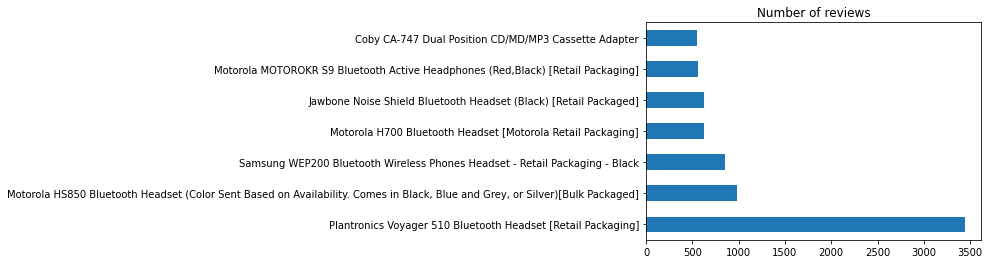

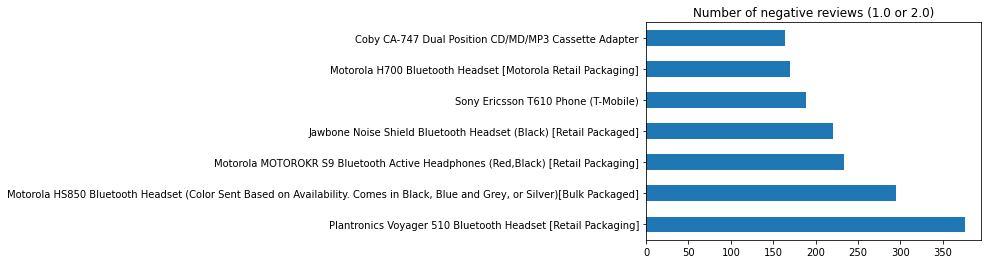

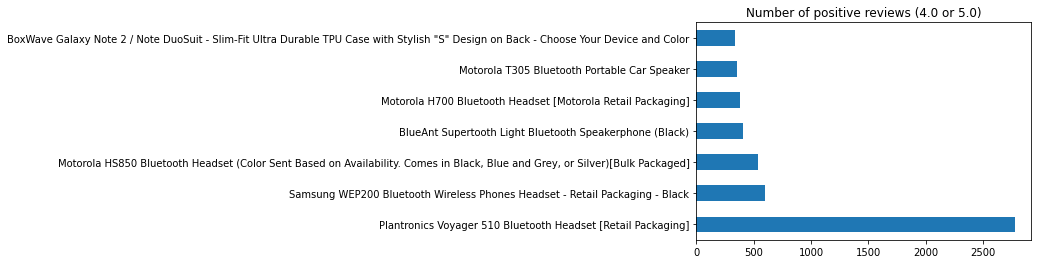

In [14]:
df['product/title'].value_counts()[:7].plot.barh( )
products_most_reviewed = df['product/title'].value_counts()[:8].drop("", errors='ignore')
products_most_reviewed.plot.barh(title="Number of reviews")
plt.show()

products_most_neg_reviewed = \
    df[df['review/score'] < 3.0]['product/title'].value_counts()[:7].drop("", errors='ignore')
products_most_neg_reviewed.plot.barh(title="Number of negative reviews (1.0 or 2.0)")
plt.show()

products_most_pos_reviewed = \
    df[df['review/score'] > 3.0]['product/title'].value_counts()[:8].drop("", errors='ignore')
products_most_pos_reviewed.plot.barh(title="Number of positive reviews (4.0 or 5.0)")
plt.show()

In [15]:
def sns_hist(series: pd.Series, title="", figsize=(15, 8), xlim = None, **kwargs):
    '''
    Plots a seaborn histogram.
    Args:
        series: pd.Series with the data to plot
        title: title of the plot
        figsize: size of the figure
        **kwargs: passed to the sns.histplot function 
    '''
    plt.figure(figsize=figsize)
    if xlim is not None:
        plt.xlim(xlim)
    plt.title(title)
    sns.histplot(series, **kwargs)
    plt.show()

In [16]:
sns.set_palette("muted")

**People are more likely to rate a product as being very good or very bad than something in the middle.**

In [17]:
review_score_counts = df['review/score'].value_counts().sort_index()

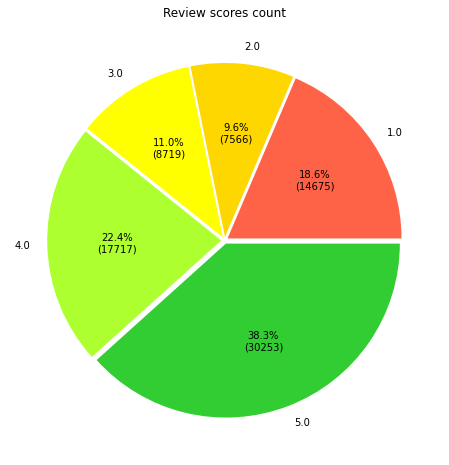

In [18]:
def count_from_pct(pct, allvals):
    '''
    Calculates the number having its percentage.
    '''
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.figure(figsize=(8, 8))
plt.title('Review scores count')
plt.pie(review_score_counts, explode = [0.02 for i in range(len(review_score_counts))], 
            labels = review_score_counts.index, autopct= lambda pct: count_from_pct(pct, review_score_counts),
       colors = ['tomato', 'gold', 'yellow', 'greenyellow', 'limegreen'])
plt.show()

In [19]:
def get_words_frequency_from_text(text: str):
    '''
    Calculates the words frequency in a given text. 
    To skip stop words, artifact words, etc. it uses a simple heuristics - 
    selects words than are at least 3 charactes long. It also deletes stopwords provided by nltk.corpus.stopwords
    and punctuation. Before counting the words, text is lowercased.
    Args:
        text - string from which the function will calculate word frequencies
    Returns:
        dictionary with word counts
    '''
    text = str.lower(text).translate(str.maketrans('', '', string.punctuation))
    text_container = text.split()
    counts = Counter([word for word in text_container if len(word) > 3])
    for word in stopwords.words('english'):
        counts.pop(word, 0)
    return counts

In [20]:
def get_words_frequency_from_df(df: pd.DataFrame, column_name: str):
    '''
    Sums up all of the texts from the series df[column_name] and calculates 
    words frequency using get_words_frequency_from_text function. 
    Args:
        df: DataFrame that contains a column with documents
        column_name: name of the column of df that contains the documents (strings)
    Returns:
        dict with the word frequencies.
    '''
    texts_series = df[column_name]
    text_sum = ""
    for text in tqdm(texts_series):
        text_sum += text + " "
    return get_words_frequency_from_text(text_sum)

In [21]:
def sort_dict(dictionary):
    '''
    Sorts a dictionary in a descending order
    '''
    return sorted(dictionary.items(), key=lambda x: x[1], reverse=True)

In [22]:
# Creating two DataFrames: one with positive reviews and a second one with negative reviews
negative_reviews_df = df[df['review/score'] < 3.0]
positive_reviews_df = df[df['review/score'] > 3.0]

# Calculating the words frequencies for 'review/text' column
negative_reviews_word_freq = sort_dict(get_words_frequency_from_df(negative_reviews_df, 'review/text'))
positive_reviews_word_freq = sort_dict(get_words_frequency_from_df(positive_reviews_df, 'review/text'))

# Calculating the words frequencies for 'review/summary' column
negative_summary_word_freq = sort_dict(get_words_frequency_from_df(negative_reviews_df, 'review/summary'))
positive_summary_word_freq = sort_dict(get_words_frequency_from_df(positive_reviews_df, 'review/summary'))

100%|████████████████████████████████████████████████████████████████████████| 47970/47970 [00:00<00:00, 543094.50it/s]


In [23]:
# Taking the top 10 most frequently occuring words in review/text
top_words_from_neg_revs = np.array(negative_reviews_word_freq[:10])
top_words_from_pos_revs = np.array(positive_reviews_word_freq[:10])

# Taking the top 10 most frequently occuring words in review/summary
top_words_from_neg_summary = np.array(negative_summary_word_freq[:10])
top_words_from_pos_summary = np.array(positive_summary_word_freq[:10])

In [24]:
def word_frequencies_hist(word_frequencies: np.ndarray, title: str, figsize=(15, 10)):
    '''
    Plots words frequencies using sns.histplot().
    Args:
    word_frequencies: np.ndarray with shape (A x 2), where A is the number of words. 
        Each row should consist of [word, number of occurences]
    title: title for the plot
    '''
    plt.figure(figsize=figsize)
    sns.histplot(x=word_frequencies[:, 0], 
                 weights = word_frequencies[:, 1].astype(int))
    plt.title(title)
    plt.show()

## The top ten most frequently occuring words in positive and negative reviews. 

### Entire reviews
There aren't any adjectives among the most frequent words in negative reviews. However, positive reviews contain a few of them - e.g. "good" or "great". <br/>
Both of these groups are dominated by product names like "phone", "battery" or "headset". <br/>
The tenth most common word in negative reviews is 'dont' which probably comes from descriptions of malfunctioning products and customers expressing their dislike.  

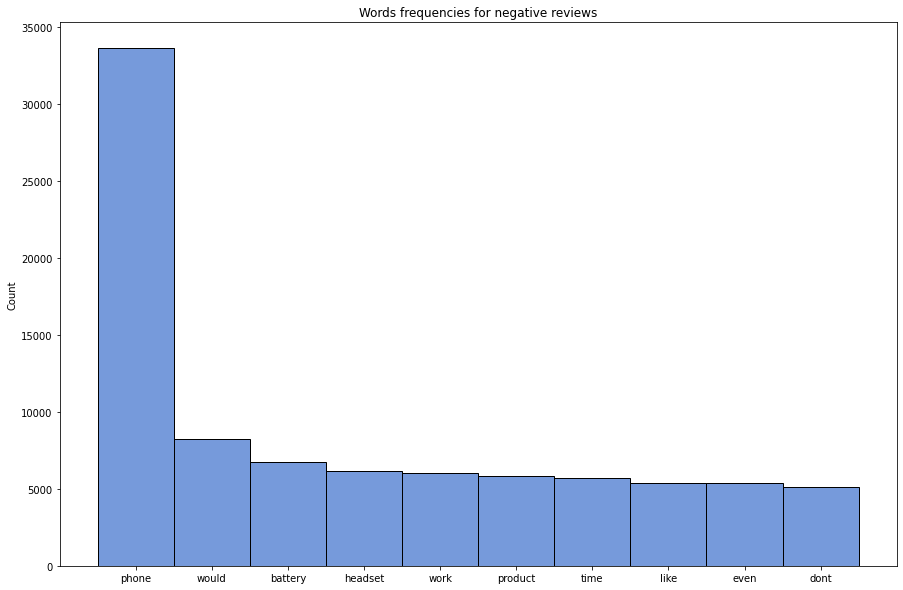

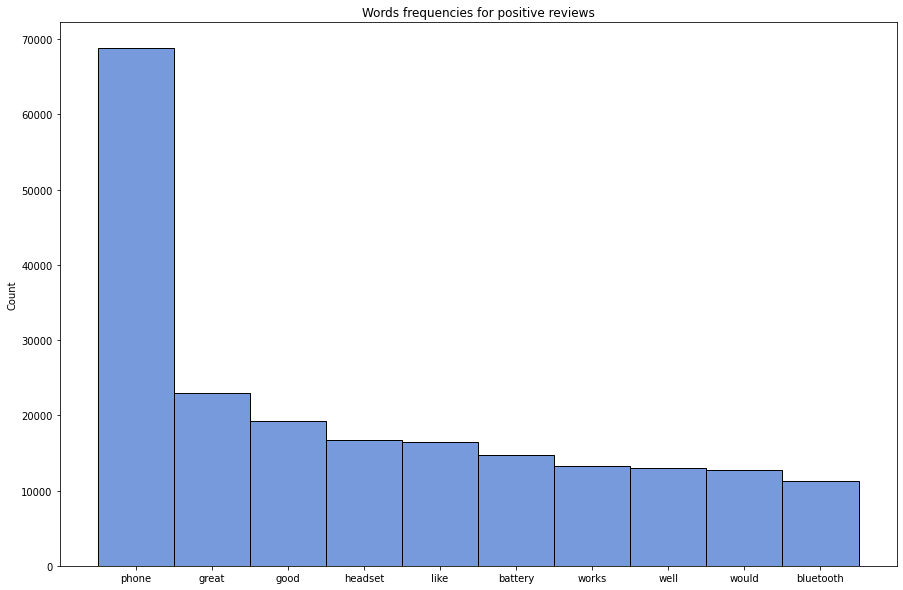

In [25]:
word_frequencies_hist(top_words_from_neg_revs, "Words frequencies for negative reviews")
word_frequencies_hist(top_words_from_pos_revs, "Words frequencies for positive reviews")

### Reviews' summaries
Based on the words frequencies, we can see that summaries are more concrete. Both negative and positive summaries include many adjectives. <br/> Product names are no longer so clearly dominant words.

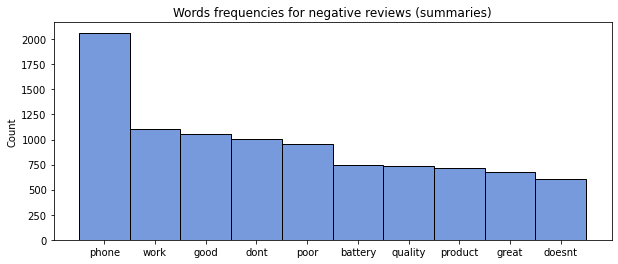

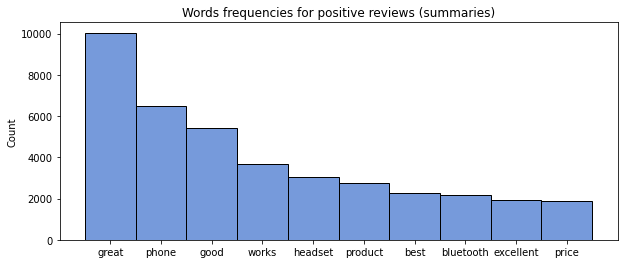

In [26]:
word_frequencies_hist(top_words_from_neg_summary, "Words frequencies for negative reviews (summaries)", figsize = (10, 4))
word_frequencies_hist(top_words_from_pos_summary, "Words frequencies for positive reviews (summaries)", figsize = (10, 4))

# What exactly does a score of 3/5 mean?
It's pretty obvious that in a five point rating scale one and two mean negative review, while four and five indicate positive review. However, I find three to be an ambiguous score. To check the actual nature of reviews with that scoring, I will use a pretrained LSTM model for sentiment analysis provided by flair framework. Since this neural net has been trained on IMDB reviews, the Amazon products reviews should not be a problem for it. 

Let's start with a sanity check of the model by predicting the sentiment of the reviews with score 1 and 5. 

In [27]:
def prediction_from_flair_sentence(sentence: flair.data.Sentence):
    '''
    Args:
        sentence: flair.data.Sentence 
    Returns:
        label of the sentence. Label is a string - 'POSITIVE' or 'NEGATIVE'
    '''
    return str(sentence.labels[0]).split()[0]

In [28]:
def find_sentence_by_prediction(original_sentences: pd.Series, flair_sentences: pd.Series, prediction: str):
    '''
    Searches for the first sentence that was classified as a {prediction} argument. 
    Args:
        original_sentences: pd.Series with strings 
        sentences_as_tokens: pd.Series with classified flair.data.Sentence
        prediction: string, either 'POSITIVE' or 'NEGATIVE'
    Returns:
        string with the sentence classified as the {prediction} argument. If such doesn't exists,
        "NOT_FOUND" will be returned. 
    
    '''
    for index, flair_sentence in enumerate(flair_sentences):
        if prediction_from_flair_sentence(flair_sentence) == prediction:
            return original_sentences.iloc[index]
    return "NOT_FOUND"

In [29]:
def get_classified_sentences(text_series: pd.Series, sentiment_model) -> pd.Series:
    '''
    Classifies each text in the text_series using sentiment_model.
    Returns: 
        Series with classified flair.data.Sentences
    '''
    # Changing the representation of text to the flair.data.Sentence
    text_series_tokens = text_series.apply(lambda text: flair.data.Sentence(text))
    # Applying the model
    text_series_tokens.apply(lambda flair_sentence: sentiment_model.predict(flair_sentence))
    return text_series_tokens

In [30]:
def get_prediction_counts(sentence_series: pd.Series) -> pd.Series:
    '''
    Args:
        sentence_series: pd.Series of classified flair.data.Sentences
    Returns:
        counts (as pd.Series) of 'POSITIVE' and 'NEGATIVE' labels in sentence_series
    '''
    return sentence_series.apply(lambda sentence: prediction_from_flair_sentence(sentence)).value_counts()

In [31]:
def pie_chart(counts, figsize = (8, 8), title = ""):
    '''
    Creates a pie chart based on the counts series.
    Args:
        counts: counts of the values to plot. Assumes that it consists of 'POSITIVE' and 'NEGATIVE' indexes.
        figsize: figsize to use
        title: title of the plot
    '''
    colors = ['#ff9999', '#8ef28d']
    if counts.index[0] == 'POSITIVE':
        colors.reverse()
    plt.figure(figsize = figsize)
    plt.pie(counts, explode = [0.02 for i in range(len(counts))], 
            labels = counts.index, autopct='%1.1f%%',
           colors = colors)
    plt.title(title)
    plt.show()

In [32]:
# Loading the model
sentiment_model = flair.models.TextClassifier.load('en-sentiment')
clear_output()

In [33]:
# Creating samples of negative and positive reviews that will be classified 
neg_rev_sample = df[df['review/score'] == 1.0].sample(n=400)['review/text']
pos_rev_sample = df[df['review/score'] == 5.0].sample(n=400)['review/text']

In [34]:
%%time
# Classifying the reviews
neg_rev_sample_as_tokens = get_classified_sentences(neg_rev_sample, sentiment_model)
pos_rev_sample_as_tokens = get_classified_sentences(pos_rev_sample, sentiment_model)

Wall time: 1min 13s


Classification results for the negative reviews (score 1.0):
NEGATIVE    400
Name: review/text, dtype: int64

Exemplary missclassified review:
NOT_FOUND



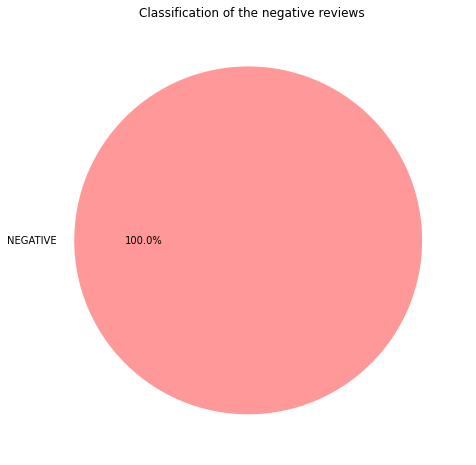

In [35]:
# Checking if there are any negative reviews classified as positive.

counts = get_prediction_counts(neg_rev_sample_as_tokens)
print("Classification results for the negative reviews (score 1.0):\n{}".format(counts))
missclassified_text = find_sentence_by_prediction(neg_rev_sample, neg_rev_sample_as_tokens, "POSITIVE")
print("\nExemplary missclassified review:\n{}\n".format(missclassified_text))
pie_chart(counts, title="Classification of the negative reviews")



Classification results for the positive reviews (score 5.0):
POSITIVE    360
NEGATIVE     40
Name: review/text, dtype: int64

Exemplary missclassified review:
I purchased this phone before reading all of these reviews but I can say I am glad I didnt read these first. I probably would not have purchased the phone. I am not having any of the problems that have been stated here so I think they might have just had a bad phone or something because mine works great. I think it is a great work horse type phone it is not loaded with a bunch of extras just the stuff you really need in a phone. The speaker phone is the one of the best I have heard that is the reason I bought it by the way, anyway no echo or anything like that I can use it even driving in the car with the road noise with out any problems so I thought that was great nice and clear not breaking up or anything. Also it comes with ready link which I think is going to be a big feature in the future once everyone else gets phones wit

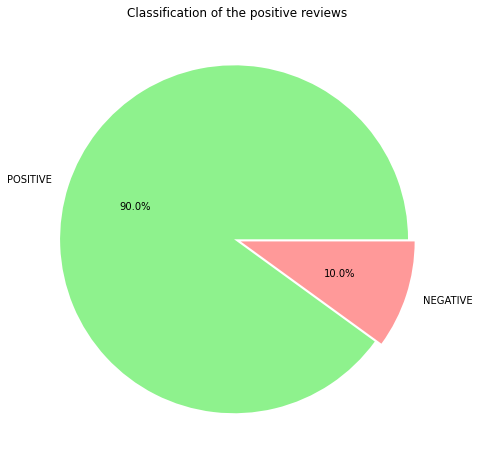

In [36]:
# Checking if there are any positive reviews classified as negative.

counts = get_prediction_counts(pos_rev_sample_as_tokens)
print("\n\nClassification results for the positive reviews (score 5.0):\n{}".format(counts))
missclassified_text = find_sentence_by_prediction(pos_rev_sample, pos_rev_sample_as_tokens, "NEGATIVE")
print("\nExemplary missclassified review:\n{}\n".format(missclassified_text))
pie_chart(counts, title="Classification of the positive reviews")

With accuracy over 95% for negative reviews and about 90% for positive, we can assume that the model performs decently on our dataset. <br/><br/>
**We can now apply it to the reviews with score of 3.**

In [37]:
# Classifying a sample of 500 reviews with score of 3.0
rev_sample = df[df['review/score'] == 3.0].sample(n=500)['review/text']
classified_sentences = get_classified_sentences(rev_sample, sentiment_model)

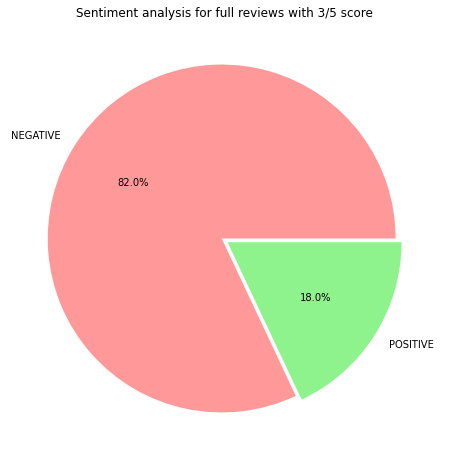

In [38]:
pie_chart(get_prediction_counts(classified_sentences), title="Sentiment analysis for full reviews with 3/5 score")

**And do the same for the summaries of reviews.**

In [39]:
# Since summaries are much shorter, I can classify a bigger sample in about the same time
rev_sample = df[df['review/score'] == 3.0].sample(n=1000)['review/summary']
classified_sentences = get_classified_sentences(rev_sample, sentiment_model)

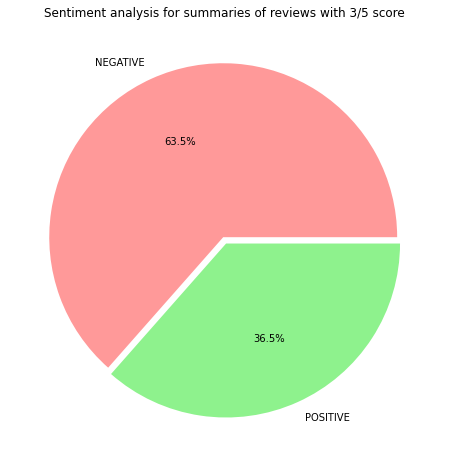

In [40]:
pie_chart(get_prediction_counts(classified_sentences), title="Sentiment analysis for summaries of reviews with 3/5 score")

**According to the flair’s model, most of the full reviews with a score of 3 are in fact negative.** <br/>
When considering the summaries of the reviews, the classification is a bit more ambiguous. About **62% of summaries are negative** and **38% is positive**. Having in mind that the classifier is imperfect (only ~90% accuracy for the full reviews with 5 score), I cannot say without a doubt that negative summaries dominate over the positive when considering score of 3. <br/>
Summarizing, my guess not to use 3 score reviews when calculating the words frequencies for positive/negative opinions was probably correct. 

### Naive Bayes for sentiment analysis
I'll compare the flair's LSTM model results with a Naive Bayes classifier trained on reviews with score 1 and 5. <br/>
I will use the train/test split of 70%/30%.

In [41]:
class PipelineClassifier:
    '''
    Wrapper for the sklearn Pipeline that is used for classyfing text as 'POSITIVE' or 'NEGATIVE' 
    '''
    
    def __init__(self, 
                 pipeline = [('vect', CountVectorizer()),
                             ('tfidf', TfidfTransformer()),
                             ('clf', MultinomialNB())]
                ):
        self.classifier = Pipeline(pipeline)
        
    def train(self, train_X, train_Y):
        self.classifier.fit(train_X, train_Y)
        
    def predict(self, data):
        return self.classifier.predict(data)
    
    def score(self, data_X, data_Y):
        return self.classifier.score(data_X, data_Y)
    
    def get_results(self,test: pd.DataFrame, X_name, Y_name):
        '''
        Classififies the data from the test DataFrame.
        Labels should be strings 'POSITIVE' and 'NEGATIVE'
        Args:
            test: DataFrame to test on
            X_name: name of the column with the features
            Y_name: name of the column with the labels
        Returns:
            Tuple:
            (classification results for positive samples from test,
            classification results for negative samples from test,
            total accuracy)
        '''
        test_pos_labels = test[test[Y_name] == 'POSITIVE']
        test_neg_labels = test[test[Y_name] == 'NEGATIVE']
        pos_classified = self.predict(test_pos_labels[X_name])
        neg_classified = self.predict(test_neg_labels[X_name])
        pos_successes = (pos_classified == 'POSITIVE').sum()
        neg_successes = (neg_classified == 'NEGATIVE').sum()
        acc = (pos_successes + neg_successes) / len(test) * 100
        return pos_classified, neg_classified, acc 

In [42]:
def split_data(df, target_column, features_column, test_size = 0.3):
    '''
    Does a split on a dataframe filtered from target_column values that differ from 1.0 or 5.0. 
    Args:
        df: DataFrame to perform a split on
        target_column: name of the column with target labels
        features_column: name of the column with features (documents)
        test_size: size of the test set 
    Returns:
        tuple: 
        (df with (1-test_size * 100)% records as a train set, 
        df with (test_size * 100)% records as a test set)
    '''
    # Filtering the dataframe to get only the reviews with 1.0 and 5.0 score. 
    df_for_nb = df[(df[target_column] == 1.0) | (df[target_column] == 5.0)][[features_column, target_column]]
    # Changing the labels to 'POSITIVE' and 'NEGATIVE'
    df_for_nb[target_column] = df_for_nb[target_column].astype(str).apply(lambda score:
                                                                           'POSITIVE' if score == '5.0' else 'NEGATIVE')
    # Spliting the data into train and test
    return train_test_split(df_for_nb, test_size = 0.3)

In [43]:
# Spliting the data into train and test sets, creating the classifier, training it on train set and testing on the test set
train, test = split_data(df, 'review/score', 'review/text')
nb_clf = PipelineClassifier()
nb_clf.train(train['review/text'], train['review/score'])
positive_revs_result, negative_revs_result, acc = nb_clf.get_results(test, 'review/text', 'review/score')

### Naive Bayes results for an unbalanced data set

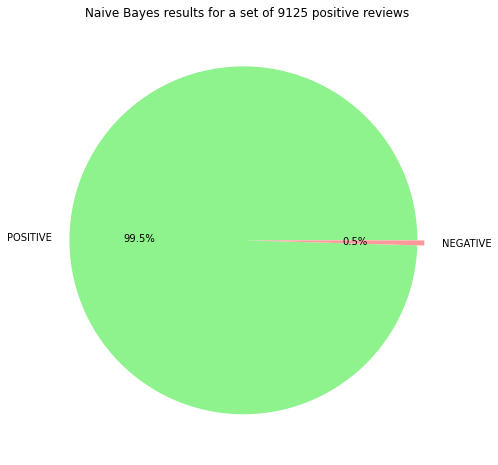

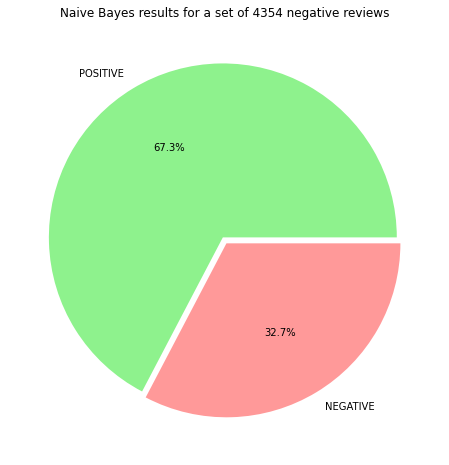

In summary, Naive Bayes achieves accuracy of 77.936%.


In [44]:
pie_chart(
    pd.Series(positive_revs_result).value_counts(),
    title='Naive Bayes results for a set of {} positive reviews'.format(len(positive_revs_result))
)
pie_chart(
    pd.Series(negative_revs_result).value_counts(),
    title='Naive Bayes results for a set of {} negative reviews'.format(len(negative_revs_result))
)
print("In summary, Naive Bayes achieves accuracy of {:.3f}%.".format(acc))

It performed great on the positive reviews, but very poorly on the negatives - worse than a random classifier would. The reason of that might be an unbalanced dataset - there's much more reviews with a score of 5 than with the 3.<br/>
To fix that, I will create an evenly distributed dataset by getting rid of extra reviews with a score of 5. 

In [45]:
def split_data_balanced(df, target_column, features_column, test_size = 0.3):
    '''
    Does a split on a dataframe filtered from target_column values that differ from 1.0 or 5.0. 
    DataFrame is cleared of extra records with target of 5.0 so that the split would be performed
    on a balanced data set. 
    Args:
        df: DataFrame to perform a split on
        target_column: name of the column with target labels
        features_column: name of the column with features (documents)
        test_size: size of the test set 
    Returns:
        tuple: 
        (df with (1-test_size * 100)% records as a train set, 
        df with (test_size * 100)% records as a test set)
    '''
    df_with_ones = df[df[target_column] == 1.0][[features_column, target_column]]
    df_with_fives = df[df[target_column] == 5.0][[features_column, target_column]].sample(len(df_with_ones))
    df_for_nb = pd.concat((df_with_ones, df_with_fives))

    df_for_nb[target_column] = df_for_nb[target_column].astype(str).apply(lambda score:
                                                                           'POSITIVE' if score == '5.0' else 'NEGATIVE')
    # Spliting the data into train and test
    return train_test_split(df_for_nb, test_size = test_size)

In [46]:
# Splitting the data to balanced train and test sets, creating the model, 
# training it on train set and getting the results for test set. 
train, test = split_data_balanced(df, 'review/score', 'review/text')
nb_clf = PipelineClassifier()
nb_clf.train(train['review/text'], train['review/score'])
positive_revs_result, negative_revs_result, acc = nb_clf.get_results(test, 'review/text', 'review/score')

### Naive Bayes results for a balanced data set

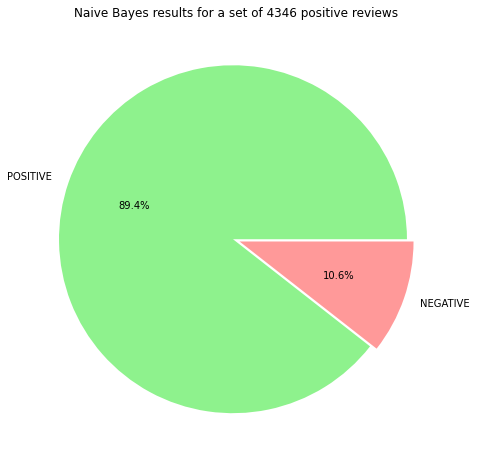

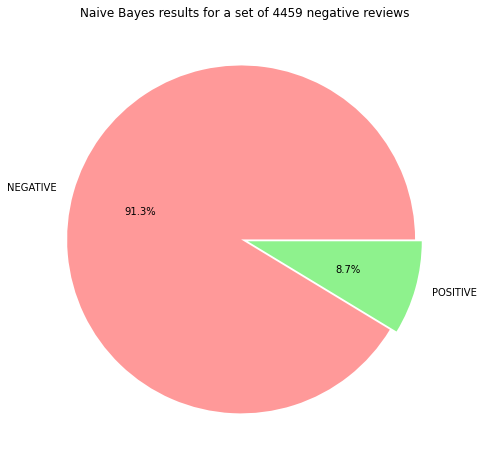

In summary, Naive Bayes achieves accuracy of 90.392%.


In [47]:
pie_chart(
    pd.Series(positive_revs_result).value_counts(),
    title='Naive Bayes results for a set of {} positive reviews'.format(len(positive_revs_result))
)
pie_chart(
    pd.Series(negative_revs_result).value_counts(),
    title='Naive Bayes results for a set of {} negative reviews'.format(len(negative_revs_result))
)
print("In summary, Naive Bayes achieves accuracy of {:.3f}%.".format(acc))

Now the classifier achieves a much better accuracy - around 90% for both positive and negative reviews. <br/>
Having this model, I will again classify reviews with a score of 3/5.

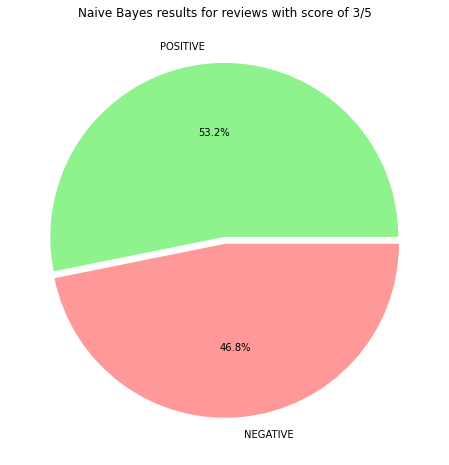

In [48]:
# Classyfing the whole set of the full reviews with score of 3/5
neutral_revs = df[df['review/score'] == 3.0]['review/text']
predictions = nb_clf.predict(neutral_revs)
pie_chart(
    pd.Series(predictions).value_counts(),
    title='Naive Bayes results for reviews with score of 3/5'
)

The results are much different than the ones from the LSTM. <br/>According to the Naive Bayes Classifier, there's nearly a perfect 50% / 50% split between positive and negative reviews that give a product a score of 3/5. 

# Creating a better metric for measuring the helpfulness of a review

Right now, the measurement of the review helpfulness is a fraction of people who liked the review. It's not very informative and can be misleading too - a review seen by only 1 person will be rated as perfect if this person liked it. It will even be counted as better than a review seen by 1000 customers, 999 of whom found it helpful. <br/>
To fix it, I will use a Lower bound of Wilson score confidence interval for a Bernoulli parameter (which is supposedly used by Reddit). It treats the review votes as a sample from hypothetical set of votes made by all of the customers. Then, with 95% confidence, it calculates what would be the lower bound for a fraction of people who found the review helpful when considering the full customer population. New reviews seen only by 1 or 2 customers won't be counted as helpful since there's not enough data to confirm that. The more people will see the review and vote, the better the accuracy of the review helpfulness score will be. <br/><br/>
*Source that I used to find out how this score works: https://www.evanmiller.org/how-not-to-sort-by-average-rating.html*

In [49]:
def conf_lower_bound(pos_votes, all_votes, confidence = 0.95) -> float:
    '''
    Args:
        pos_votes - number of positive votes
        all_votes - number of all votes
        confidence - confidence bound we want to use. Since we use z hardcoded as 1.96, it's 0.95 by default
    Returns:
        Lower bound of Wilson score confidence interval for a Bernouli parameter
    '''
    if all_votes == 0:
        return float(0)
    z = 1.96  
    phat = float(pos_votes) / all_votes
    return round(
        ((phat + z * z / (2 * all_votes) - z * np.sqrt((phat * (1 - phat) + z * z /(4 * all_votes)) / all_votes)) 
        / (1+z*z/all_votes)),
        3)

In [50]:
def add_helpfulness_metric(df: pd.DataFrame, metric_name = 'review/helpfulnessLowerBound') -> df:
    '''
    Uses the vectorized conf_lower_bound function to create a new column with 
    lower bound of Wilson score confidence interval for a Bernoulli parameter from 
    'review/helpfulnessCount' and 'review/viewsCount' and adds it to the df. 
    '''
    vectorized_conf_fun = np.vectorize(conf_lower_bound)
    df[metric_name] =  vectorized_conf_fun(
        df['review/helpfulnessCount'].to_numpy(),
        df['review/viewsCount'].to_numpy()
    )
    return df 

New metric will be stored in a 'review/helpfulnessLowerBound' column. Since the max value of it is 0.99 there's no need to normalize this column.

In [51]:
df = add_helpfulness_metric(df)
df.describe()

,review/score,review/helpfulnessCount,review/viewsCount,review/helpfulnessFraction,review/helpfulnessLowerBound
count,78930.000000,78930.000000,78930.000000,78930.000000,78930.000000
mean,3.523337,3.041581,3.956810,0.426029,0.182556
std,1.524245,12.302882,13.354536,0.454090,0.235306
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,1.000000,1.000000,0.125000,0.027000
75%,5.000000,3.000000,4.000000,1.000000,0.342000
max,5.000000,1222.000000,1243.000000,1.000000,0.990000


Random sample showing how the new metric compares to the vote statistics:

In [52]:
df[['review/helpfulnessCount', 'review/viewsCount', 
    'review/helpfulnessFraction', 'review/helpfulnessLowerBound']].sample(10)

,review/helpfulnessCount,review/viewsCount,review/helpfulnessFraction,review/helpfulnessLowerBound
4536,6,8,0.75,0.409
23972,0,0,0.00,0.000
75291,0,0,0.00,0.000
47665,0,0,0.00,0.000
75756,0,0,0.00,0.000
70113,18,18,1.00,0.824
67964,0,0,0.00,0.000
14,0,0,0.00,0.000
30036,6,6,1.00,0.610
2277,0,0,0.00,0.000


Based on the histograms below, we can see that the new metric behaves much more naturally. There is no sudden jump in the number of reviews as rating approaches 1.0. This jump occurs in the old metric and is caused by the reviews with very low number of votes.

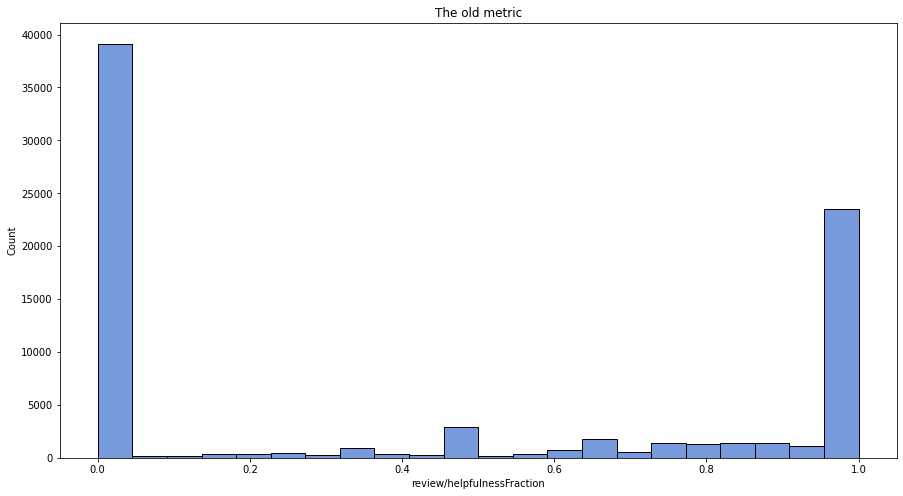

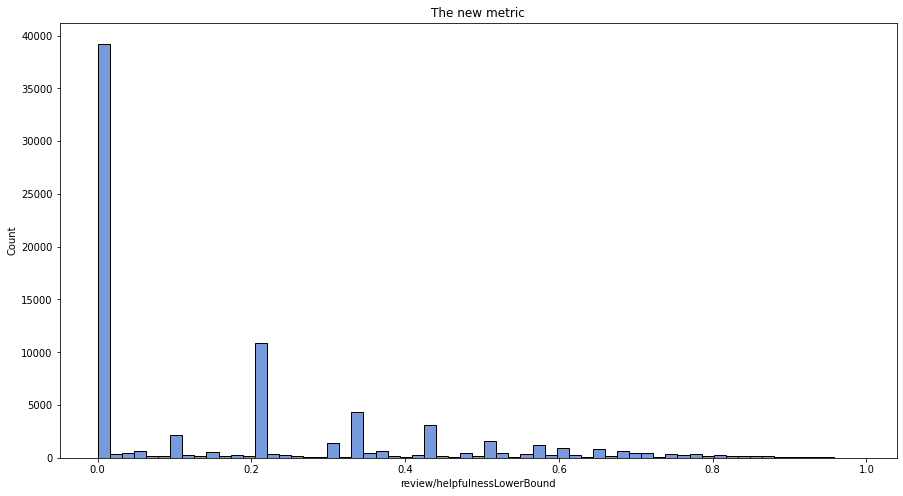

In [53]:
sns_hist(df['review/helpfulnessFraction'], title='The old metric')
sns_hist(df['review/helpfulnessLowerBound'], title='The new metric')

# Calculating the length of reviews and summaries

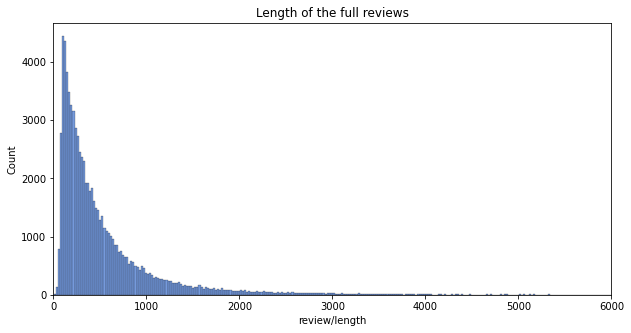

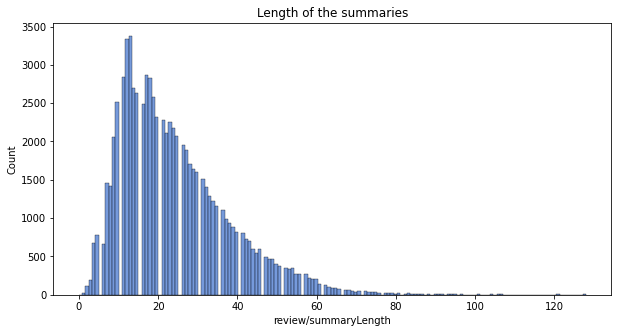

In [54]:
vectorize_len = np.vectorize(len)
df['review/length'] = vectorize_len(df['review/text'])
df['review/summaryLength'] = vectorize_len(df['review/summary'])
sns_hist(df['review/length'], 'Length of the full reviews', (10, 5), xlim = (0, 6000))
sns_hist(df['review/summaryLength'], 'Length of the summaries', (10, 5))

# Correlation between the variables
With a proper helpfulness metric and lenght of the reviews, I want to check if there is any correlation between the variables. To do so, I will use Pearson's correlation coefficient measure. 

In [55]:
# Before working with the product/price column, the rows with 'unknown' price have to be deleted
df_price = df[df['product/price'] != 'unknown'].reset_index(drop=True)
change_column_type(df_price, 'product/price', float)

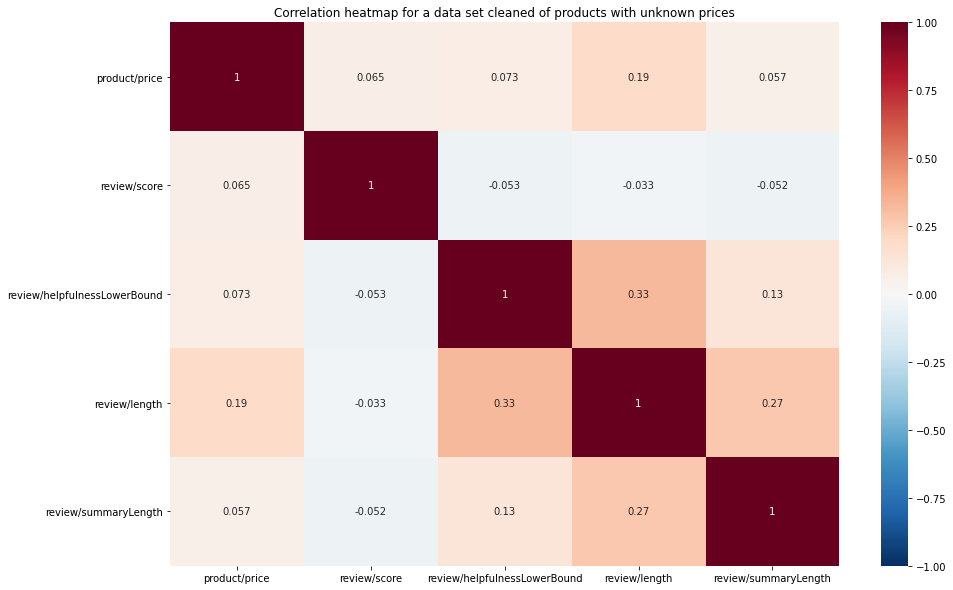

In [56]:
plt.figure(figsize=(15, 10))
plt.title('Correlation heatmap for a data set cleaned of products with unknown prices')
sns.heatmap(df_price[['product/price', 'review/score', 'review/helpfulnessLowerBound', 
                      'review/length', 'review/summaryLength']].corr(),
            annot=True, vmin = -1, vmax = 1, cmap = 'RdBu_r')
plt.show()

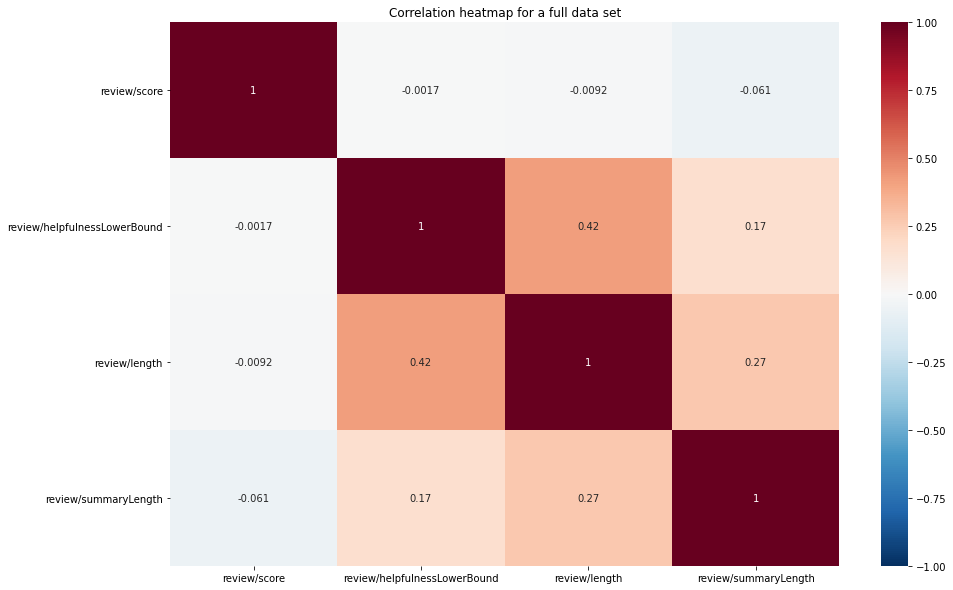

In [57]:
plt.figure(figsize=(15, 10))
plt.title('Correlation heatmap for a full data set')
sns.heatmap(df[['review/score', 'review/helpfulnessLowerBound', 
                      'review/length', 'review/summaryLength']].corr(),
            annot=True, vmin = -1, vmax = 1, cmap = 'RdBu_r')
plt.show()

I've found three linear relationships:
* The obvious one - length of the full review is correlated with the review's summary's length (Pearson's coefficient of 0.27).
* There is a strong association between review's length and its helpfulness measured as a lower bound of Wilson score - the longer the review is, the more likely it is to be recognized as helpful. Correlation coefficient is 0.42.  
* Price of a product is slightly correlated (0.19) with with the product's review's length. This is a very self-explanatory relationship. If a product was expensive, people were more likely to spend extra time and effort writing a review.